In [2]:
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from ml.common.data_utils.data_modules import HiggsDataset
from ml.common.data_utils.syn_datacreator import create_custom_multidim_dataset
from ml.diffusion.ddpm.model import NoisePredictorUNet

from ml.diffusion.score.model import RefineNet, SimpleUNet, ModularUNet
from ml.diffusion.score.score_matching import score_matching_loss, linear_noise_scale, geometric_noise_scale, maximum_eucl_dist
from ml.diffusion.score.langevin_dynamics import sample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

c:\Users\Uporabnik\Documents\IJS-F9\JanGit\MLHEPsim-master\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\Uporabnik\Documents\IJS-F9\korlz\ml\diffusion\score


device(type='cpu')

In [3]:
noise_scales = linear_noise_scale(length=10)
noise_scales

tensor([1.0000, 0.8900, 0.7800, 0.6700, 0.5600, 0.4500, 0.3400, 0.2300, 0.1200,
        0.0100])

Synthetic data

In [9]:
batch_size=512

In [10]:
N_FEATURES = 3

datasetraw = create_custom_multidim_dataset(n_samples=20000, n_features=N_FEATURES, label_random=True, signal_frac=0.5, seed=123)
print("dataset shape:", datasetraw.shape)   # (10000, 3)
print(datasetraw[:5])

dataset shape: (20000, 4)
[[-3.550892  -1.0142367 -7.4624577  0.       ]
 [ 4.622796   1.6087942  3.7642446  1.       ]
 [-4.515475  -2.5092688 -3.500204   0.       ]
 [-4.6891136 -4.7863035 -4.834843   0.       ]
 [-3.4597535 -3.6463473 -4.970148   0.       ]]


In [11]:
features_syn = [f'f{i}' for i in range(N_FEATURES)]

In [12]:
# X_syn, labels_syn = datasetraw[:, :-1], datasetraw[:, -1][:, None]
train_data_syn, val_data_syn = train_test_split(datasetraw, train_size=0.8)

print(train_data_syn.shape, val_data_syn.shape)
train_dataset_syn = HiggsDataset(train_data_syn)
val_dataset_syn = HiggsDataset(val_data_syn)

batches_train = DataLoader(train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True)
batches_val = DataLoader(train_dataset_syn, num_workers=0, batch_size=batch_size, shuffle=True)

X_syn, labels_syn = next(iter(batches_train))

# fig, ax = plt.subplots(N_FEATURES, 1)
# for idx, feature in enumerate(features_syn[:N_FEATURES]): 
#     sns.histplot(X_syn[:, idx][:, None], bins=30, ax=ax[idx])
# plt.show()

(16000, 4) (4000, 4)


In [13]:
maxim = []

for x, _ in batches_train:
    maxim.append(maximum_eucl_dist(x))

sigma_start = max(maxim)
sigma_start

5.516881750971704

In [14]:
# prep noise scales
N_NOISE_SCALES = 10

noise_scales = linear_noise_scale(length=N_NOISE_SCALES).to(device)
# noise_scales = geometric_noise_scale(start=1., end=0.01, length=N_NOISE_SCALES).to(device)

#reshape data
IMG_SHAPE = (1, 3, 1) 
assert np.prod(IMG_SHAPE) == N_FEATURES, "Image shape must match number of features"

#instantiate model
model = RefineNet(
    in_channels=IMG_SHAPE[0],
    hidden_channels=(16, 32, 64, 128), 
    n_noise_scale=N_NOISE_SCALES
).to(device)

modelsmall = SimpleUNet(
    in_channels=IMG_SHAPE[0],
    n_noise_scale=N_NOISE_SCALES
)

modelflex = ModularUNet(
    in_channels=IMG_SHAPE[0],
    base_channels=64,                # Number of channels in the first layer
    channel_mults=(1, 2),            # Channels will be (64, 128)
    num_res_blocks=2,                # Two ResNet blocks per level
    use_attention_at_level=(False, True) # Use attention at the 128-channel level
)

In [15]:
#loss test
batch, _ = next(iter(batches_train))
reshaped_features = batch.view(-1, *IMG_SHAPE) 

loss = score_matching_loss(modelflex, reshaped_features, noise_scales)
loss.item()

1.0881439447402954

In [16]:
def train(model, train_dataloader, val_dataloader, device, max_epochs=10, lr=1e-3):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=1e-6)
    
    epoch_train_loss = []
    epoch_val_loss = []

    for epoch in range(max_epochs):
        model.train()
        train_loss = []
        loop = tqdm(train_dataloader, leave=False,
                    desc=f"Epoch {epoch+1}/{max_epochs} training")
        
        for features_batch, _ in loop:
            optimizer.zero_grad()
            features_batch = features_batch.to(device)
            reshaped_features = features_batch.view(-1, *IMG_SHAPE) # -> (batch_size, 1, 3, 1)

            loss = score_matching_loss(model, reshaped_features, noise_scales)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            loop.set_postfix({'batch_loss': f"{loss.item():.4f}"})  

        epoch_avg = float(np.mean(train_loss)) if len(train_loss) > 0 else 0.0
        epoch_train_loss.append(epoch_avg)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{max_epochs} | avg_loss={epoch_avg:.4f} | LR={current_lr:.6f}")

        model.eval()
        val_loss = []
        loop_val = tqdm(val_dataloader, leave=False,
                        desc=f"Epoch {epoch+1}/{max_epochs} validation")
        with torch.no_grad():
            for features_batch_val, _ in loop_val:
                features_batch_val = features_batch_val.to(device)
                reshaped_features_val = features_batch_val.view(-1, *IMG_SHAPE) # -> (batch_size, 1, 3, 1)


                loss_val = score_matching_loss(model, reshaped_features_val, noise_scales)
                val_loss.append(loss_val.item())
                loop_val.set_postfix({'val_batch_loss': f"{loss_val.item():.4f}"})

        epoch_avg_val = float(np.mean(val_loss)) if len(val_loss) > 0 else 0.0
        epoch_val_loss.append(epoch_avg_val)
        print(f"Epoch {epoch+1}/{max_epochs} | avg_loss_val={epoch_avg_val:.4f}")

        # sch update
        scheduler.step()

    return model, epoch_train_loss, epoch_val_loss

In [18]:
model_trained, epoch_train_loss, epoch_val_loss = train(
    modelflex, batches_train, batches_val, device, max_epochs=20, lr=1e-4
)

Epoch 1/20 | avg_loss=0.5559 | LR=0.000100


Epoch 1/20 | avg_loss_val=0.5308


Epoch 2/20 | avg_loss=0.4909 | LR=0.000099


Epoch 2/20 | avg_loss_val=0.4663


Epoch 3/20 | avg_loss=0.4760 | LR=0.000098


Epoch 3/20 | avg_loss_val=0.4655


Epoch 4/20 | avg_loss=0.4448 | LR=0.000095


Epoch 4/20 | avg_loss_val=0.4580


Epoch 5/20 | avg_loss=0.4568 | LR=0.000091


Epoch 5/20 | avg_loss_val=0.4409


Epoch 6/20 | avg_loss=0.4442 | LR=0.000086


Epoch 6/20 | avg_loss_val=0.4419


Epoch 7/20 | avg_loss=0.4437 | LR=0.000080


Epoch 7/20 | avg_loss_val=0.4497


Epoch 8/20 | avg_loss=0.4542 | LR=0.000073


Epoch 8/20 | avg_loss_val=0.4378


Epoch 9/20 | avg_loss=0.4508 | LR=0.000066


Epoch 9/20 | avg_loss_val=0.4373


Epoch 10/20 | avg_loss=0.4391 | LR=0.000058


Epoch 10/20 | avg_loss_val=0.4440


Epoch 11/20 | avg_loss=0.4438 | LR=0.000051


Epoch 11/20 | avg_loss_val=0.4372


Epoch 12/20 | avg_loss=0.4415 | LR=0.000043


Epoch 12/20 | avg_loss_val=0.4428


Epoch 13/20 | avg_loss=0.4440 | LR=0.000035


Epoch 13/20 | avg_loss_val=0.4474


Epoch 14/20 | avg_loss=0.4393 | LR=0.000028


Epoch 14/20 | avg_loss_val=0.4451


Epoch 15/20 | avg_loss=0.4448 | LR=0.000021


Epoch 15/20 | avg_loss_val=0.4371


Epoch 16/20 | avg_loss=0.4361 | LR=0.000015


Epoch 16/20 | avg_loss_val=0.4341


Epoch 17/20 | avg_loss=0.4420 | LR=0.000010


Epoch 17/20 | avg_loss_val=0.4407


Epoch 18/20 | avg_loss=0.4367 | LR=0.000006


Epoch 18/20 | avg_loss_val=0.4382


Epoch 19/20 | avg_loss=0.4389 | LR=0.000003


Epoch 19/20 | avg_loss_val=0.4307


Epoch 20/20 | avg_loss=0.4358 | LR=0.000002


Epoch 20/20 | avg_loss_val=0.4367


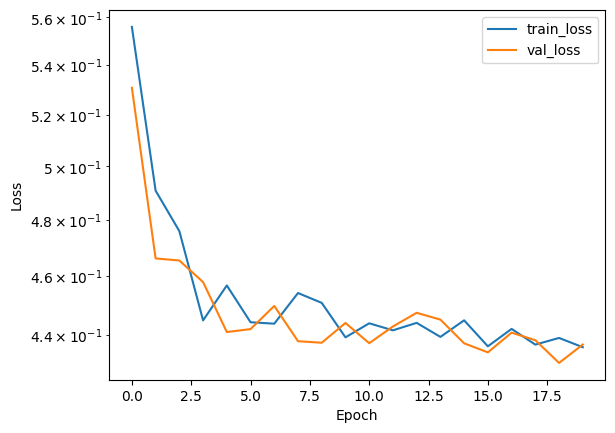

In [19]:
plt.plot(epoch_train_loss, label='train_loss')
plt.plot(epoch_val_loss, label='val_loss')
plt.yscale("log")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [26]:
sample_count = 1000

In [27]:
sample_shape = (sample_count, *IMG_SHAPE)
samples_2d = sample(model_trained, sample_shape, noise_scales, device, n_steps=100, eps=2e-4)

samples = samples_2d.view(sample_count, N_FEATURES)

print(f"Successfully generated {sample_count} samples.")
print("Shape of generated data (original format):", samples.shape)

if isinstance(samples, torch.Tensor):
    samples = samples.cpu().numpy()

Annealed Langevin Dynamics: 100%|██████████| 10/10 [07:19<00:00, 43.99s/it]

Successfully generated 1000 samples.
Shape of generated data (original format): torch.Size([1000, 3])


In [28]:
#real data (not in batches)
real, real_l = datasetraw[:, :-1], datasetraw[:, -1][:, None]

scaler = preprocessing.StandardScaler().fit(real)

real = scaler.transform(real)

if isinstance(real, torch.Tensor):
    real = real.cpu().numpy()

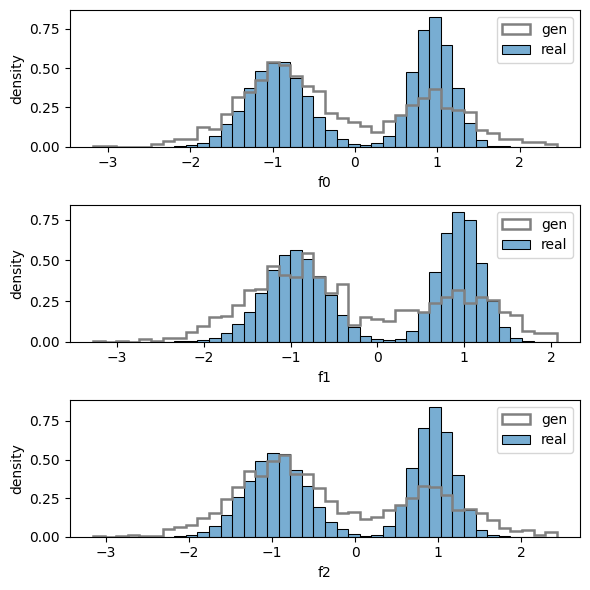

In [29]:
features_list = globals().get("features_syn", [f"f{i}" for i in range(N_FEATURES)])

fig, axes = plt.subplots(N_FEATURES, 1, figsize=(6, 2 * N_FEATURES), sharex=False)
if N_FEATURES == 1:
    axes = [axes]

for idx, ax in enumerate(axes):
    combined = np.concatenate([real[:, idx], samples[:, idx]])
    bins = np.histogram_bin_edges(samples[:, idx], bins=40)

    sns.histplot(real[:, idx], bins=bins, ax=ax, stat="density", color='C0', alpha=0.6, label='real')
    ax.hist(samples[:, idx], bins=bins, density=True, histtype='step', lw=1.8, color='gray', label='gen')

    ax.set_xlabel(features_list[idx])
    ax.set_ylabel("density")
    ax.legend()

plt.tight_layout()
plt.show()